# Analyze SAXS Data on Nanoparticles in Water

The following code analyzes SAXS data on 50 +/- 3 nm SiO2 nanoparticles dispersed in water obtained during beamtime from 3/27/19-4/1/19 at the Argonne Photon Source (APS).

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

from scipy.signal import medfilt2d

import saxs
import saxsplot

from importlib import reload
reload(saxs)
reload(saxsplot)

# PARAMETERS
data_folder_path = '..\\..\\EXPERIMENTS\\APS\\APS_NP_MF_DEVICE\\SAXS\\flow\\'
filename_structure = 'flow_hs104_*.tif'
r_lim = (15,500)
phi_lim = (-np.pi/2, 0)
averaged_coord = 'phi'
signal_scan_list = [176, 177, 178, 179, 180, 181]
signal_scan = 181
bkgd_scan_list = [175]
water_scan_list = [175, 182]
air_scan_list = [174]

## Load Data

We first load the images of SAXS patterns from the data and subtract the water background from them as a demonstration of the analysis software.

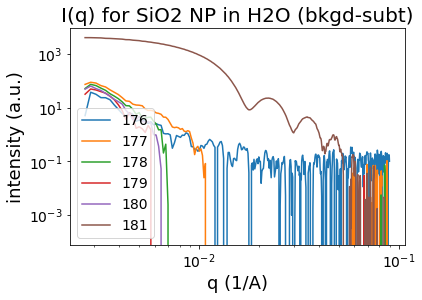

In [17]:
# Get file path
filepath_structure = os.path.join(data_folder_path,filename_structure)
file_list = glob.glob(filepath_structure)

# Average background intensities
bkgd_file_list = saxs.get_scan_filenames(bkgd_scan_list, file_list)
bkgd_mean, _, q = saxs.compute_stats(bkgd_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)

# Organize data structures for intensity for each scan of data
file_list_by_scan = [saxs.get_scan_filenames([scan], file_list) for scan in signal_scan_list]
q_list = []
intensity_list = []
label_list = []

# Average results from each scan and subtract background
for i in range(len(file_list_by_scan)):
    scan_file_list = file_list_by_scan[i]
    scan, _ = saxs.parse_scan_trial(scan_file_list[0])
    scan_mean, _, q = saxs.compute_stats(scan_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)    
    intensity_subt = scan_mean - bkgd_mean
    # Store results
    q_list += [q]
    intensity_list += [intensity_subt]
    label_list += [str(scan)]
    
# Plot background-subtracted data
saxsplot.plot(q_list, intensity_list, label_list=label_list, title='I(q) for SiO2 NP in H2O (bkgd-subt)')

## Characterize Background Signal

We wish to measure the background strength, variation in the background signal among trials within the same scan, and the drift in the background signal over time.

We begin with the mean and standard devaition of the air background (which includes the quartz capillary of the flow cell) and the water background.

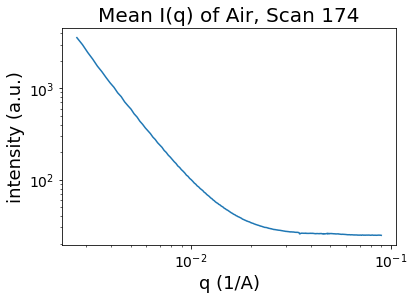

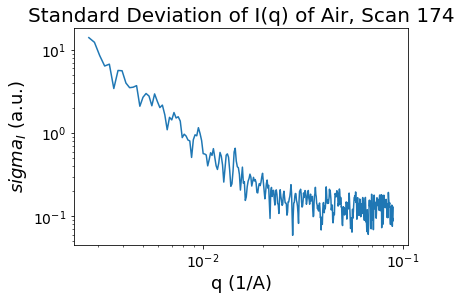

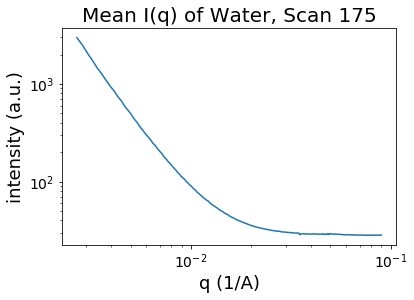

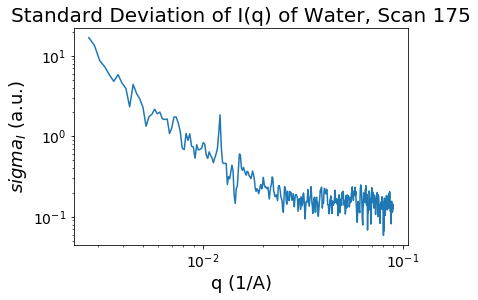

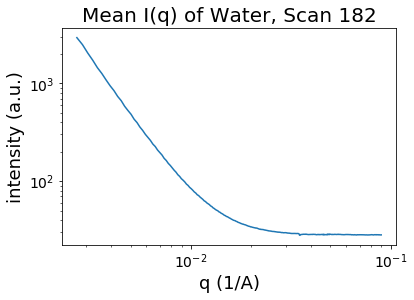

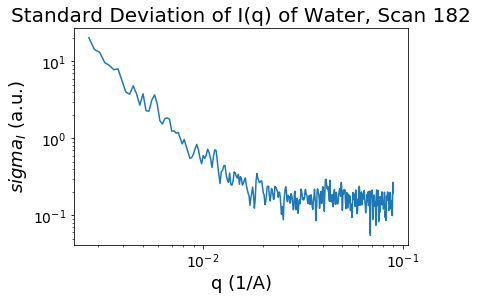

In [26]:
# Average and standard deviation of background signal of air
for scan in air_scan_list:
    air_file_list = saxs.get_scan_filenames(scan, file_list)
    air_mean, air_std, q = saxs.compute_stats(air_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    saxsplot.plot([q], [air_mean], title='Mean I(q) of Air, Scan {scan}'.format(scan=scan))
    saxsplot.plot([q], [air_std], title='Standard Deviation of I(q) of Air, Scan {scan}'.format(scan=scan),
                 y_label=r'$\sigma_I$ (a.u.)')

# Average and standard deviation of background signals of water
for scan in water_scan_list:
    water_file_list = saxs.get_scan_filenames(scan, file_list)
    water_mean, water_std, q = saxs.compute_stats(water_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    saxsplot.plot([q], [water_mean], title='Mean I(q) of Water, Scan {scan}'.format(scan=scan))
    saxsplot.plot([q], [water_std], title='Standard Deviation of I(q) of Water, Scan {scan}'.format(scan=scan),
                 y_label=r'$\sigma_I$ (a.u.)')

Next we estimate the variation in the background water signal over time (drift). These scans were taken roughly 1 hour apart.

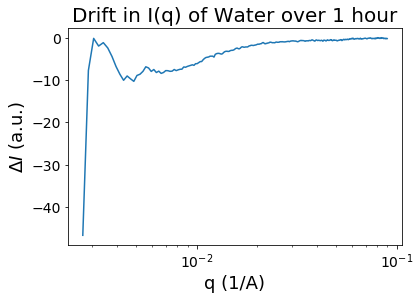

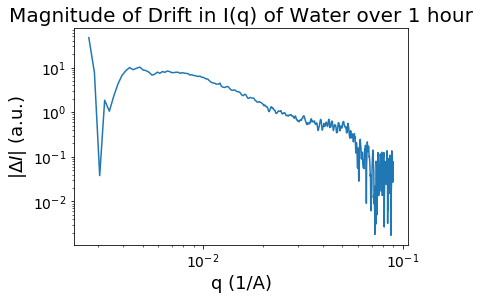

In [31]:
# Measure drift in background signal of water by subtracting mean from separate scans
mean_list = []
for scan in water_scan_list:
    water_file_list = saxs.get_scan_filenames(scan, file_list)
    water_mean, _, q = saxs.compute_stats(water_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
    mean_list += [water_mean]
diff = mean_list[1] - mean_list[0]
saxsplot.plot([q], [diff], title='Drift in I(q) of Water after 1 hour', y_label=r'$\Delta I$ (a.u.)', yscale='linear')
saxsplot.plot([q], [np.abs(diff)], title='Magnitude of Drift in I(q) of Water after 1 hour', y_label=r'$\|\Delta I\|$ (a.u.)')

## Characterize Signal to Noise

In this section we compare the strength of the background to the signal strength and the noise in the signal.

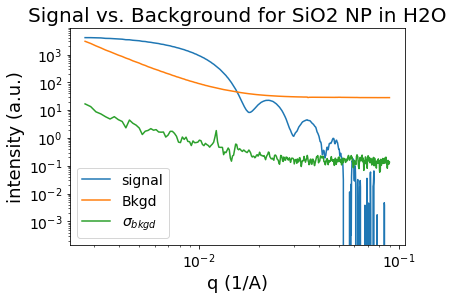

In [35]:
# Organize data structures for signal scan, background, and fluctuations
signal_file_list = saxs.get_scan_filenames(signal_scan, file_list)
q_list = []
y_list = []
label_list = []

# Average results from signal scan and subtract background
scan_mean, scan_std, q = saxs.compute_stats(scan_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)    
intensity_subt = scan_mean - bkgd_mean
# Store results
q_list += [q]
y_list += [intensity_subt]
label_list += ['signal']

# Include background and standard deviation
bkgd_file_list = saxs.get_scan_filenames(bkgd_scan_list, file_list)
bkgd_mean, bkgd_std, q = saxs.compute_stats(bkgd_file_list, averaged_coord, phi_lim=phi_lim, r_lim=r_lim)
q_list += [q, q]
y_list += [bkgd_mean, bkgd_std]
label_list += ['Bkgd', r'$\sigma_{bkgd}$']

# Plot signal, background, and fluctuations
saxsplot.plot(q_list, y_list, label_list=label_list, title='Signal vs. Background for SiO2 NP in H2O')